# Block Cipher and RSA

In [2]:
# import modules here
from random import randint
from Cryptodome.Cipher import AES
from Cryptodome.Util.Padding import pad, unpad
from matplotlib import pyplot as pl
import numpy as np

## Block Cipher and AES

Block ciphers, unlike the stream cipher, encrypts the message in a block-wise manner: it is split in several blocks which share the same size.
The block cipher is a sequence of rounds where each round is composed of different layers which aim at providing diffusion and confusion. 
Each round has two inputs which are: the partial result of the previous round and a key which is the result of the key expansion. 

AES is a kind of block cipher that was standardized in 2001 by the NIST agency and replaced the insecure Data Encryption Algorithm(DES).

The general structure of the AES is composed of two main parts which are the *Key Schedule* and the *Data Path*:

- Key Schedule: its purpose is to transform the input key into the $N_r+1$ round keys, where Nr is the number of rounds and the additional key is referring to the first Key addition layer. The number of rounds depend on the length of the key, for instance: with a key of 128-bit we have #rounds = 10, with a key of 192-bit we have #rounds = 12 and with a key of 256-bit we have #rounds = 14.

- Datapath: It is composed of rounds and each round is a sequence of 3 layers: 
    - Linear Mixing Layer: It is used to provide diffusion and it is composed of two sublayers which are the *Shift Row Layer* and the *Mix Column Layer*.
    - Non Linear Layer: It is used to provide diffusion and implements a *Byte substitution layer* 
    - Key Addition Layer: This is essential to avoid the inversion of the layers because their implementation is public and what is unknown is the key. This let us compute the intermediate state as the xor of the state and the round key. 
    
All the rounds follow the above structure except for the first one where there is only a *Key addition layer* and the last one where there *Mixed Column layer* is missing.

### Modes of operation

Whenever a message is longer than a block there are different ways to encode it and they are called *Mode Of Operation*:

- Electronic Code Block (ECB): it splits the message into blocks coherent with the block cipher and each block is encoded independently with one another.

- Cipher Block Chaining(CBC): The result of the current block does not depend only on the input plaintext but it is mixed with the result of the previous block.

- Cipher Feedback (CFB): The result of the block is the mixing of the plaintext and the result of the Block Cipher whose input is the feedback of the output of the previous Block Cipher. Besides, the first block cipher has as input the Initialization Vector

- Counter (CTR): There is no feedback in this mode but a counter that is increased at every iteration and we have a nonce to make the value of the counter not predictable.

Load the plaintext stored as `secret_message.bin`.
The plaintext is a serialized 2048 x 2912 grayscale image in which each pixel is an 8bit integer. Serialization transformed the 2D image into a byte string by concatenating the rows and transforming each 8bit pixel into a byte.

In [3]:
def read_bin(file_name):
    with open(file=file_name, mode='rb') as file:
        try:
            bin_file = file.read()
            return bin_file
        except(IOError, OSError):
            return "It appears an error occurred while reading your file"

vectorized_im = read_bin('secret_message.bin')

Process the plaintext in order to retrive the original image and then visualize it.

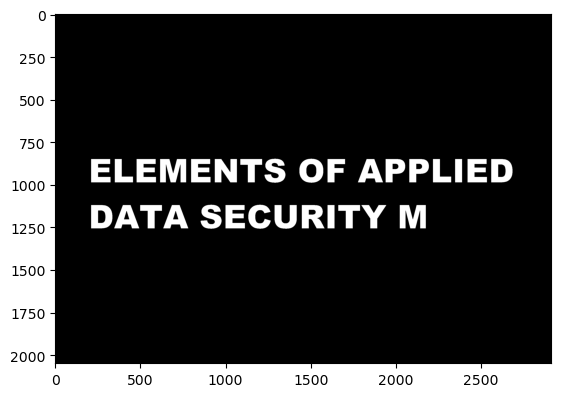

In [4]:
plaintext_unrolled = np.reshape(np.array(list(vectorized_im)), (2048, 2912))
pl.imshow(plaintext_unrolled, cmap='gray')
pl.show()

Using AES, for each operation mode (ECB, CBC, CTR and CFB) encrypt and decrypt the image

In [5]:
key = b'0123456701234567'

sender_ecb = AES.new(key, AES.MODE_ECB)
receiver_ecb = AES.new(key, AES.MODE_ECB)

ciphertext_ecb = sender_ecb.encrypt(vectorized_im)
plaintext_ecb = np.reshape(np.array(list(receiver_ecb.decrypt(ciphertext_ecb))), (2048, 2912))

sender_cfb = AES.new(key, AES.MODE_CFB)
receiver_cfb = AES.new(key, AES.MODE_CFB, IV=sender_cfb.IV)

ciphertext_cfb = sender_cfb.encrypt(vectorized_im)
plaintext_cfb = np.reshape(np.array(list(receiver_cfb.decrypt(ciphertext_cfb))), (2048, 2912))

sender_cbc = AES.new(key, AES.MODE_CBC)
receiver_cbc = AES.new(key, AES.MODE_CBC, IV=sender_cbc.IV)

ciphertext_cbc = sender_cbc.encrypt(vectorized_im)
plaintext_cbc = np.reshape(np.array(list(receiver_cbc.decrypt(ciphertext_cbc))), (2048, 2912))

sender_ctr = AES.new(key, AES.MODE_CTR)
receiver_ctr = AES.new(key, AES.MODE_CTR, nonce=sender_ctr.nonce)

ciphertext_ctr = sender_ctr.encrypt(vectorized_im)
plaintext_ctr = np.reshape(np.array(list(receiver_ctr.decrypt(ciphertext_ctr))), (2048, 2912))


For each mode of opration visualize the ciphertext as an image

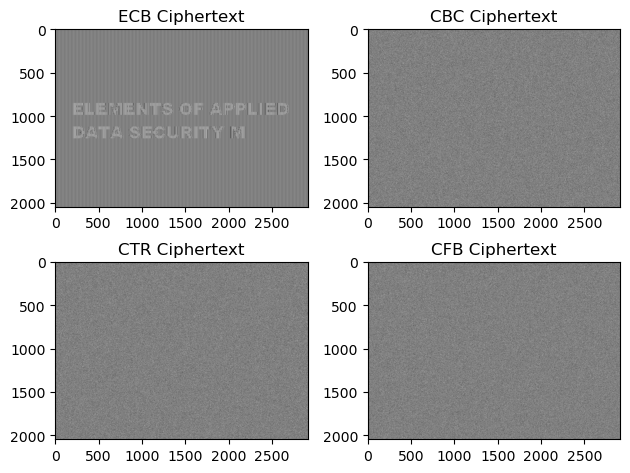

In [6]:
plaintext_unrolled = np.reshape(np.array(list(vectorized_im)), (2048, 2912))
fig, ax = pl.subplots(2,2)
ax[0,0].imshow(np.reshape(np.array(list(ciphertext_ecb)), (2048, 2912)), cmap='gray')
ax[0,0].set_title('ECB Ciphertext')
ax[0,1].imshow(np.reshape(np.array(list(ciphertext_cbc)), (2048, 2912)), cmap='gray')
ax[0,1].set_title('CBC Ciphertext')
ax[1,0].imshow(np.reshape(np.array(list(ciphertext_ctr)), (2048, 2912)), cmap='gray')
ax[1,0].set_title('CTR Ciphertext')
ax[1,1].imshow(np.reshape(np.array(list(ciphertext_cfb)), (2048, 2912)), cmap='gray')
ax[1,1].set_title('CFB Ciphertext')
fig.tight_layout()
pl.show()

For each mode of operation we visualize the plaintext:

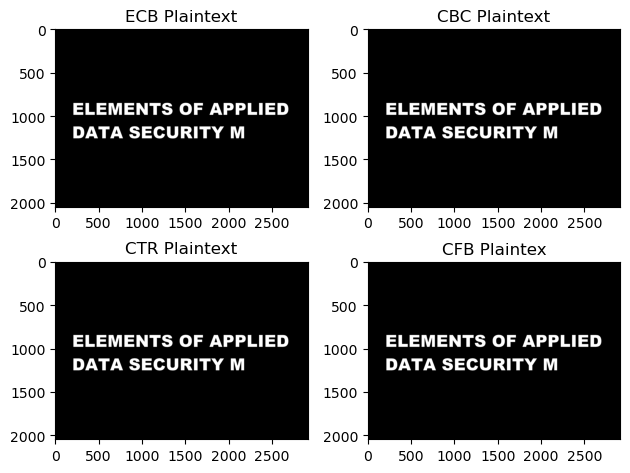

In [7]:
plaintext_unrolled = np.reshape(np.array(list(vectorized_im)), (2048, 2912))
fig, ax = pl.subplots(2,2)
ax[0,0].imshow(plaintext_ecb, cmap='gray')
ax[0,0].set_title('ECB Plaintext')
ax[0,1].imshow(plaintext_cbc, cmap='gray')
ax[0,1].set_title('CBC Plaintext')
ax[1,0].imshow(plaintext_ctr, cmap='gray')
ax[1,0].set_title('CTR Plaintext')
ax[1,1].imshow(plaintext_cfb, cmap='gray')
ax[1,1].set_title('CFB Plaintex')
fig.tight_layout()
pl.show()

With a quick glance at the ciphertexts it is clear that the mode of operation ECB is the less secure one since the ciphertext we obtain is visually almost equivalent as the input plaintext since there is little diffusion. This happens because such mode of operation encodes each block separately and doesn't introduce any correlation between the different blocks.

The sender and receiver of the two modes CFB and CBC also need to have the same Initialization Vector which acts as a starting point for both the encryption and decryption.

The CTR mode does not need any initialization vector but both sender and receiver require the same *nonce* which makes the counter unpredictable.

## RSA

RSA is an asymmetric encryption algorithm where there is a public and a private key. They are both generated by the receiver but the public key is the only one that is sent to the sender and it does not need a secure communication channel to exchange it, unlike what happens in an asymmetric encryption algorithms. 

The encryption and decryption formulas used are the following:

<p align = "center">
<img src="RSA_formulas.PNG" width="22%" height="22%">
</p>

The RSA algorithm is based onto integer-factorization: in particular we wish to find two big prime numbers *p* and *q* which are at least 512-bit each and multiply them together to find *n* which is the key length(In today's practical applications the key length is usually 2048-bit)
Then the Totient of *n* is computed quite easily since we know the factorization of *n*, in fact the RSA is based on the fact that the Totient of *n* can be considered a non invertible function which is computationally too hard to compute if we don't know a factorization of *n*.
The public exponent *e* is a number whose great common divisor with the Totient of *n* must be equal to one in order to have a modulo inverse which in this case it is *d* that is the private exponent.



### Square and Multiply

Both the encryption and decryption formulas used in the RSA need an exponentiation with quite big numbers which would require a lot of computational power. In order to tackle this issue we rely on the Square and Multiply algorithm where the huge number of multiplications we would have in case of an exponentiation are substituted with a multiplication by x and a squaring when we have an addition by 1 and multiplication by 2 respectively.

In [8]:
def square_and_multiply(base, exp, mod):
    exp_list = [int(i) for i in bin(exp)[2:]]
    y = 1

    for i in exp_list:
        y = pow(y, 2, mod)
        if i == 1:
            y = (y * base) % mod

    return y

testing

In [9]:
print(f'The result of the Square and Multiply algorithm is: {square_and_multiply(2, 256, 21)}')
print(f'The result of a standard exponentiation is: {(2**256) % 21}')

The result of the Square and Multiply algorithm is: 16
The result of a standard exponentiation is: 16


### Miller Rabin test

The Miller Rabin test is used in order to test whether a number is prime or not. 

The algorithm is based onto the Fermat's Little Theorem $x^p \equiv p  (mod p)$ which can be rewritten as $x^{(p-1)} - 1 \equiv 0  (mod p)$ and the right hand side is factorized. If at least one of the factors is congruent to 0 then we can assert that there is a high probability that the number analyzed is indeed prime. 



In [18]:
def _comp_coeff(number):
    r, q1 = 0, number - 1
    while q1 % 2 == 0:
        r += 1
        q1 //= 2
    return q1, r


def miller_rabin_test(prime_num, num_trials=None):
    if prime_num == 2 or prime_num == 3:
        return True
    q, r = _comp_coeff(prime_num)
    for _ in range(num_trials):
        x = randint(2, prime_num - 2)
        y = square_and_multiply(x, q, prime_num)
        if y == 1 or y == prime_num - 1:
            continue
        for _ in range(r):
            y = square_and_multiply(y, 2, prime_num)
            if y == prime_num - 1:
                break
        else:
            return False
    return True

testing

In [19]:
NR_TRIALS = 100
print(f'Is the number 5 prime? {miller_rabin_test(5, NR_TRIALS)}')
print(f'Is the number 15 prime? {miller_rabin_test(15, NR_TRIALS)}')

Is the number 5 prime? True
Is the number 15 prime? False


### Extended Eucledian Algorithm

The Extended Eucledian Algorithm is used in order to find the modulo inverse of a number *a* with respect to the modulo *m*. 

The basic idea is that the great common divisor can be expressed as a linear combination: $gcd(a,m) = a*s + m*t$. Moreover, the modulo inverse exists as long as the following equation is satisfied: $gcd(a,m) = 1$. We can then find the relation between the two equations which leads to having that the modulo inverse is: $a^{-1} mod(m) = s$.

In [20]:
def extended_euclidean_algorithm(a, m):
    (r0, r1) = (m, a)
    (s0, s1, t0, t1) = (0, 1, 1, 0)

    while True:
        r2 = r0 % r1
        q = (r0 - r2) // r1
        (s0, s1) = (s1, s0 - q * s1)
        (t0, t1) = (t1, t0 - q * t1)
        if r2 == 0:
            break
        else:
            r0, r1 = r1, r2

    if r1 == 1:
        if s0 < 0:
            # gcd(a,m) = sign(s)a*s + sign(t)m*t -> it avoids to have negative 's'
            return int(s0 % m)
        return int(s0)
    else:
        raise ValueError("No modular inverse exists")

testing

In [21]:
print(f'The modulo inverse of a=3 and modulo 26 is: {extended_euclidean_algorithm(3,26)}')
print(f'Proof that 9 is the modulo inverse of 3 with modulo 26 -> 9*3 % 26={9*3 % 26}')

The modulo inverse of a=3 and modulo 26 is: 9
Proof that 9 is the modulo inverse of 3 with modulo 26 -> 9*3 % 26=1


### Implementation

Implement the RSA class. The role of sender (`Alice`) or receiver (`Bob`) depends on the arguments passed when an instance is created. In detail:
- if `k_pub` is passed RSA instance works as sender (`Alice`)
- Otherwise, RSA instance works as receiver (`Bob`). Therefore, it must generate `k_priv` and `k_pub`.

In [25]:
class RSA:

    def __init__(self, key_length=128, k_pub=None, mrt_trials=None):
        self.key_length = key_length
        if k_pub is not None:
            self.role = 'SENDER'
            self.key_pub = k_pub
        else:
            self.role = 'RECEIVER'
            self.key_pub, self.param = self._compute_key(mrt_trials, key_length)
            try:
                self.key_priv = extended_euclidean_algorithm(self.key_pub[1], self.param[2])
            except ValueError as err:
                print(err)

    def _compute_key(self, trials, key_length=128):
        p = self._sample_prime_number(key_length, trials)
        q = self._sample_prime_number(key_length, trials)
        n = q * p

        # totient is computed as a factorization of prime numbers
        # it is wrong to choose two same prime numbers because it reduces the security of the system
        totient = (p - 1) * (q - 1) if p != q else p * (p - 1)

        # e is found such that gcd(e,m) = 1, this means that e must be prime
        # 65537 = 2^16 + 1 is commonly used as a public exponent in the RSA cryptosystem
        # it is big enough to be secure and it has a low hamming weight hence it's not
        # computationally demanding to compute
        e = 65537

        return (n, e), (p, q, totient)

    def _sample_prime_number(self, length, mrt_trials=None):

        while True:
            # n > x where x is the length of the plaintext, which in this case is the AES key
            # the AES key is 128-bit long, hence the chosen interval is: (2^64, 2^65 -1) -> n is long 129-bit
            number = randint(2 ** (length / 2), 2 ** (length / 2 + 1) - 1)
            # since e=65537 I have to pick numbers which are not congruent to 1 modulo 65537
            # phi(n)=(p-1)(q-1) and gcd(e,phi(n))=1 if this last relation is not satisfied: gcd(e,p-1)=k
            # and we would have p-1 == 0 mod(e) which means p-1 is a multiple of e and it would mean that no module
            # inverse exists because p-1 and e are not coprime
            # basically I have to check whether the prime number found is divisible by the public exponent or not
            if miller_rabin_test(number, mrt_trials) and (lambda x: False if x % 65537 == 0 else True)(number):
                break
        return number

    def decrypt(self, y):

        return square_and_multiply(y, self.key_priv, self.key_pub[0])

    def encrypt(self, x):
        
        return square_and_multiply(x, self.key_pub[1], self.key_pub[0])

    def __str__(self):
        if self.role == 'RECEIVER':
            return f'------------------ RSA INFO ---------------- \n' \
                   f'Role: {self.role} \n' \
                   f'p, q, totient -> {self.param[0], self.param[1], self.param[2]} \n' \
                   f'Public key (n, e) -> {self.key_pub} \n' \
                   f'Private Key (d) -> {self.key_priv}'
        else:
            return f'------------------ RSA INFO ---------------- \n' \
                   f'Role: {self.role} \n' \
                   f'Public key (n, e) -> {self.key_pub} \n'

    def __repr__(self):
        if self.role == 'RECEIVER':
            return f'------------------ RSA INFO ---------------- \n' \
                   f'Role: {self.role} \n' \
                   f'p, q, totient -> {self.param[0], self.param[1], self.param[2]} \n' \
                   f'Public key (n, e) -> {self.key_pub} \n' \
                   f'Private Key (d) -> {self.key_priv}'
        else:
            return f'------------------ RSA INFO ---------------- \n' \
                   f'Role: {self.role} \n' \
                   f'Public key (n, e) -> {self.key_pub} \n'


testing

In [26]:
plaintext = 51153126146123

Bob = RSA(key_length=128, mrt_trials=1000)
Alice = RSA(k_pub=Bob.key_pub)

ciphertext = Alice.encrypt(plaintext)

x = Bob.decrypt(ciphertext)

print(Alice, Bob)
print(f'---- Plaintext ---- \n {x}')

------------------ RSA INFO ---------------- 
Role: SENDER 
Public key (n, e) -> (895551857843203965483497252113005916093, 65537) 
 ------------------ RSA INFO ---------------- 
Role: RECEIVER 
p, q, totient -> (31679264349361492867, 28269338832082258879, 895551857843203965423548648931562164348) 
Public key (n, e) -> (895551857843203965483497252113005916093, 65537) 
Private Key (d) -> 703684002494676768900789801568270217057
---- Plaintext ---- 
 51153126146123


##  RSA+AES

It is often used a hybrid cryptosystem composed by a symmetric cryptographic algorithm for the encryption and decryption of the plaintext and an asymmetric cryptographic algorithm is instead used for the key exchange. One problem that AES and any symmetric algorithm has is the key distribution: the key is shared between the sender and receiver which means that it needs a secure channel to exchange the key. 

In order to tackle this issue RSA is used because the key is a pair of public and private keys where the public key is the one that is sent to Alice and since it is public then there is no need to have a secure communication channel for the exchange. 

We can use RSA to exchange the key of the AES algorithm which instead do need a secure channel for its exchange.
Alice uses the public key to encrypt the AES key and then Bob uses its private key to decrypt it.
The AES is then used to encrypt the plaintext and send it over to Bob.

The reason why RSA is not used directly to encrypt the plaintext is due to its expensive computational power compared to AES, in fact we have to make sure that the key length of the RSA is greater than the length of the plaintext: $n > length(plaintext)$.

However, this implementation is prone to Man in The Middle Attacks.


<img src="system.png" width="600">

With the reference to the previous picture, given an AES key `k_AES = b'0123456701234567'` and a ciphertext stored in `ciphertext_AES.bin`,
simulate a system based on RSA and AES, that allows Bob to decrypt the ciphertext.

In [27]:
k_AES = b'0123456701234567'

Bob = RSA(key_length=128, mrt_trials=1000)
Alice = RSA(k_pub=Bob.key_pub)

k_aes_enc = Alice.encrypt(int.from_bytes(k_AES, "big"))
print(f'length of the encrypted AES key is {type(k_aes_enc)}')

y = read_bin('ciphertext_AES.bin')

Bob_AES = AES.new(Bob.decrypt(k_aes_enc).to_bytes(Bob.key_length // 8, "big"), AES.MODE_ECB)
x = Bob_AES.decrypt(y)

print(Alice, Bob)
print(f'---- Plaintext ---- \n {x}')

length of the encrypted AES key is <class 'int'>
------------------ RSA INFO ---------------- 
Role: SENDER 
Public key (n, e) -> (926288320739000255819502602744675783537, 65537) 
 ------------------ RSA INFO ---------------- 
Role: RECEIVER 
p, q, totient -> (33961882261874591009, 27274351686297613393, 926288320739000255758266368796503579136) 
Public key (n, e) -> (926288320739000255819502602744675783537, 65537) 
Private Key (d) -> 858756917157955300663999058573122983425
---- Plaintext ---- 
 b'Agent 007 to MI6. I am currently in an undisclosed location and have uncovered some critical information regarding the solution to a top-secret assignment. The assignment in question is code-named "Block Cipher" and the solution has been compromised by an unknown entity. It is imperative that we secure the solution before it falls into the wrong hands. My coordinates are 44.4885 N, 11.3290 E. I have obtained the location of the individual who possesses the solution, but I need immediate backup 

## Bouns task

to be defined